In [8]:
!pwd

/Users/lantzan/python/scilifelab/genscore


In [1]:
from cyvcf2 import VCF
import pandas as pd
from io import BytesIO
import os
from base64 import b64encode, b64decode
from gzip import GzipFile
import warnings
import pandas as pd
import allel

In [2]:
vcf_file_path = 'data/hd829/SNV.somatic.sweetelf.merged.clinical.ranked.vcf'

In [3]:
vcf = VCF(vcf_file_path)

In [4]:
def csq_to_dict(csq_fields, variant_csq):
    fields = variant_csq.split(",")[0].split("|")
    return dict(zip(csq_fields, fields)) 

In [14]:
def scores_to_dict(score_categories, variant_rank_result):
    category_scores = [float(x) for x in variant_rank_result.split("|")]
    return dict(zip(score_categories, category_scores))

In [6]:
def parse_vcf(vcf_file):
    csq_fields = vcf.get_header_type("CSQ")["Description"][51:].split("|")
    categories = vcf.get_header_type("RankResult")["Description"].split("|")

In [282]:
#vcf.get_header_type("GNOMADAF")

In [7]:
csq_fields = vcf.get_header_type("CSQ")["Description"][51:].split("|")
#csq_fields.index("COSMIC")

In [8]:
categories = vcf.get_header_type("RankResult")["Description"].split("|")
#categories

In [9]:
first = next(vcf)

In [10]:
fields = first.INFO["CSQ"].split(",")[0].split("|")

In [16]:
csq_dict = csq_to_dict(csq_fields, first.INFO["CSQ"])
scores_dict = scores_to_dict(categories, first.INFO.get("RankResult", "0|0|0|0|0|0"))
scores_dict
#csq_dict

{'"allele_frequency': 4.0,
 'protein_prediction': 0.0,
 'consequence': 3.0,
 'variant_call_quality_filter': 3.0,
 'lineage': 0.0,
 'clinical_significance"': 2.0}

In [279]:
csq_dict.get("gnomAD_AF")

''

In [264]:
csq_fields.index("gnomAD_AF")

56

In [280]:
#vcf.raw_header.splitlines()

In [281]:
dict(zip(categories, category_scores))

{'"allele_frequency': 4.0,
 'protein_prediction': 0.0,
 'consequence': 3.0,
 'variant_call_quality_filter': 3.0,
 'lineage': 0.0,
 'clinical_significance"': 2.0}

In [203]:
clin_sig = []
rank_score = []
rank_result = [] 
AF_Score = []
PP_Score = []
CON_Score = []
VCQF_Score = []
VAF_Score = []
CLIN_Score = []
data = {}
for record in vcf:
    clin_sig.append(record.INFO.get("CLNSIG", "not_reported"))
    rank_score.append(record.INFO.get("RankScore", "")[2:])
    rankresult = record.INFO.get("RankResult", "0|0|0|0|0|0")
    af, pp, con, vcqf, vaf, clin = float(rankresult.split("|"))
    #AF_Score.append(af)
    #PP_Score.append(pp)
    #CON_Score.append(con)
    #VCQF_Score.append(vcqf)
    #VAF_Score.append(vaf)
    #CLIN_Score.append(clin)
    #rank_result.append(record.INFO.get("RankResult", "0|0|0|0|0|0"))
    

In [202]:
#clin_sig
#rank_result
#rankresult

NameError: name 'rankresult' is not defined

In [148]:
data = []
for record in vcf:
    chrom = record.CHROM
    pos = record.POS
    ref = record.REF
    alt = record.ALT[0]
    info = dict(record.INFO)
    rank_result = info["RankResult"]
    af, pp, con, vcqf, vaf, clin = rank_result.split("|")
    rank_score = float(info["RankScore"][2:])
    annotations = info["CSQ"].split(",")
    clnsig = info.get("CLNSIG", "not_reported")
    clin_sig = []
    #for annotation in annotations:
      # if len(annotation.split("|")[csq_fields.index("CLIN_SIG")]):
          # clin_sig.append(annotation.split("|")[csq_fields.index("CLIN_SIG")])
    data.append([chrom, pos, ref, alt, af, pp, con, vcqf, vaf, clin, rank_score, clnsig])


In [149]:
df = pd.DataFrame(data, columns=["CHROM", "POS", "REF", "ALT", "AF_Score", "PP_Score", "CON_Score", "VCQF_Score", "VAF_Score", "CLIN_Score", "RankScore", "CLIN_SIG"])

In [150]:
df

,CHROM,POS,REF,ALT,AF_Score,PP_Score,CON_Score,VCQF_Score,VAF_Score,CLIN_Score,RankScore,CLIN_SIG
0,1,1756953,C,T,4,0,3,3,0,2,12.0,not_reported
1,1,4849384,T,C,4,0,1,3,0,2,10.0,not_reported
2,1,4955824,T,TA,4,0,0,0,0,2,6.0,not_reported
3,1,4955862,C,T,4,0,0,3,-1,2,8.0,not_reported
4,1,6246921,G,T,4,0,1,3,0,2,10.0,not_reported
...,...,...,...,...,...,...,...,...,...,...,...,...
8140,X,154317640,ATGTGTG,A,4,0,1,0,0,2,7.0,not_reported
8141,X,154317640,ATGTGTGTG,A,4,0,1,0,0,2,7.0,not_reported
8142,Y,14891399,T,C,4,0,1,3,-1,2,9.0,not_reported
8143,Y,22930880,G,GT,0,0,1,-6,0,2,-3.0,not_reported


In [151]:
benign = df[df["CLIN_SIG"].isin(["Benign", "Likely_benign", "Benign/Likely_benign"])]
pathogenic = df[df["CLIN_SIG"].isin(["Pathogenic", "Likely_pathogenic", "Pathogenic/Likely_pathogenic"])]

grouped_data = df.groupby("CLIN_SIG")["RankScore"].agg(["mean", "std", "count"])




In [156]:
df_b_p = pd.concat([pathogenic, benign])

In [157]:
df_b_p

,CHROM,POS,REF,ALT,AF_Score,PP_Score,CON_Score,VCQF_Score,VAF_Score,CLIN_Score,RankScore,CLIN_SIG
191,1,85736510,A,AT,4,0,8,0,0,6,18.0,Pathogenic
192,1,85736510,AT,A,0,0,8,0,0,6,14.0,Pathogenic
590,2,16082313,AC,A,4,0,8,0,0,2,14.0,Pathogenic/Likely_pathogenic
606,2,25457243,G,A,0,2,5,3,0,6,16.0,Pathogenic
887,2,209113113,G,A,4,1,5,3,0,6,19.0,Pathogenic/Likely_pathogenic
...,...,...,...,...,...,...,...,...,...,...,...,...
8100,X,129148407,T,C,0,0,2,3,0,-2,3.0,Benign
8101,X,129150144,C,G,-12,0,2,3,0,2,-5.0,Benign
8112,X,133511988,G,A,-12,0,1,3,-2,-2,-12.0,Benign
8116,X,133547693,T,TA,0,0,5,0,0,2,7.0,Benign


In [152]:
grouped_data

,mean,std,count
CLIN_SIG,,,
Benign,-0.428969,7.913791,1077
Benign/Likely_benign,0.184211,7.691583,114
Benign|drug_response,7.000000,NaN,1
Conflicting_classifications_of_pathogenicity,7.950820,5.308566,61
Conflicting_classifications_of_pathogenicity|association,10.500000,9.192388,2
Conflicting_classifications_of_pathogenicity|drug_response|other,7.000000,NaN,1
Likely_benign,6.095890,5.304947,146
Likely_benign|drug_response|other,-3.500000,0.707107,2
Likely_benign|other,1.000000,7.071068,2


NameError: name 'plt' is not defined

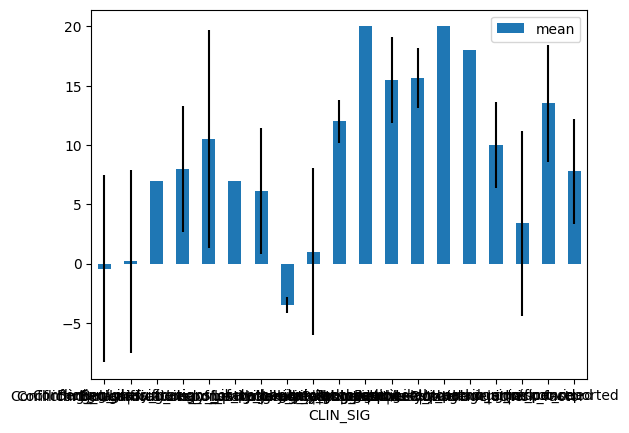

In [153]:
grouped_data.plot(kind='bar', y='mean', yerr='std', rot=0)
plt.xlabel('CLIN_SIG')
plt.ylabel('Mean RankScore')
plt.title('Mean RankScore by CLIN_SIG')
plt.show()

In [131]:
pathogenic

,CHROM,POS,REF,ALT,AF_Score,PP_Score,CON_Score,VCQF_Score,VAF_Score,CLIN_Score,RankScore,CLIN_SIG
191,1,85736510,A,AT,4,0,8,0,0,6,18,Pathogenic
192,1,85736510,AT,A,0,0,8,0,0,6,14,Pathogenic
590,2,16082313,AC,A,4,0,8,0,0,2,14,Pathogenic/Likely_pathogenic
606,2,25457243,G,A,0,2,5,3,0,6,16,Pathogenic
887,2,209113113,G,A,4,1,5,3,0,6,19,Pathogenic/Likely_pathogenic
1356,3,128204841,AC,A,4,0,8,3,0,6,21,Pathogenic
1441,3,178936091,G,A,0,2,5,3,0,6,16,Pathogenic/Likely_pathogenic
1442,3,178936103,G,A,4,1,5,3,0,6,19,Pathogenic
1443,3,178952085,A,G,0,0,5,3,0,6,14,Pathogenic
1482,4,1980558,GC,G,0,0,8,0,0,-2,6,Pathogenic
